# Fraudulent Data
## Random Forest Regressor - Consumer Fraud

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [3]:
consumer_fraud = pd.read_csv('../data/curated/consumer_fraud.csv')
#consumer_fraud.info()
display(consumer_fraud.head())

,user_id,transact_amount_perOrder,#daily_orders,#distinct_merchants,fraud_probability,transact_amount_perOrder_sd,#daily_orders_ratio,#distinct_merchants_ratio,transact_amount_perOrder_sd_ratio,transact_amount_perOrder_ratio
0,1,2479.076338,1,1,9.805431,0.000000,0.626712,0.631034,0.000000,15.307571
1,2,710.667418,3,3,9.599514,1023.234306,1.958974,1.958974,3.609439,3.842922
2,2,2236.461666,1,1,10.069851,0.000000,0.652991,0.652991,0.000000,12.093627
3,3,2334.493717,1,1,8.300636,0.000000,0.664395,0.664395,0.000000,13.958163
4,4,775.013087,3,3,9.633302,1106.645341,1.892074,1.898477,6.906554,5.385522


## Train Test Split

In [41]:
X = consumer_fraud.drop(['fraud_probability'], axis = 1)
y = consumer_fraud['fraud_probability'] #series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Tunning
**Using -RMSE as metric to tune the model**

In [27]:
param_grid = {'max_depth': (3,5,10,15,20,50), 
              'n_estimators': (10, 50, 100, 150, 200),
              'max_features': (0.85, 0.75, 0.65),
              'max_samples': (0.85, 0.75, 0.65),
              'ccp_alpha': (0, 0.01, 1, 10)}

rf=RandomForestRegressor(criterion = "squared_error")

# Perform Grid-Search
gsc = GridSearchCV(rf, param_grid, cv=3, 
                   scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, return_train_score=True)

tune_result = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


/opt/homebrew/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


**Let's take a look at the results!**

In [63]:
best_params = pd.DataFrame(tune_result.best_params_, index = ['best_params'])
cv_results1 = pd.DataFrame(tune_result.cv_results_)
#cv_results1.to_csv('../data/fraud_rfr_tuning1.csv')
display(best_params)
display(cv_results1.iloc[tune_result.best_index_])

,ccp_alpha,max_depth,max_features,max_samples,n_estimators
best_params,0,10,0.65,0.65,150


mean_fit_time                                                  3.532319
std_fit_time                                                   0.005652
mean_score_time                                                0.093074
std_score_time                                                 0.011321
param_ccp_alpha                                                       0
param_max_depth                                                      10
param_max_features                                                 0.65
param_max_samples                                                  0.65
param_n_estimators                                                  150
params                {'ccp_alpha': 0, 'max_depth': 10, 'max_feature...
split0_test_score                                             -3.628548
split1_test_score                                              -3.51103
split2_test_score                                             -3.549494
mean_test_score                                               -3

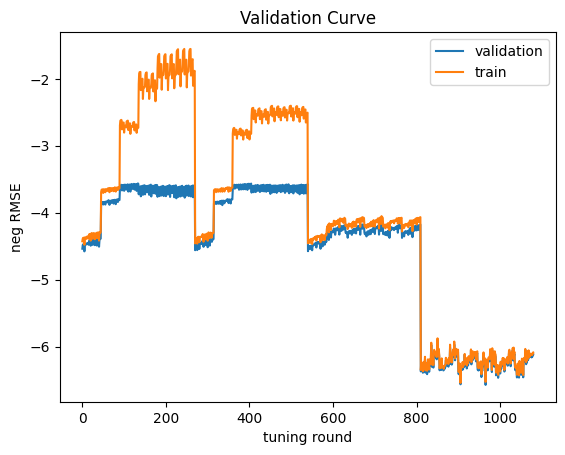

In [64]:
import matplotlib.pyplot as plt

plt.plot(cv_results1['mean_test_score'], label='validation')
plt.plot(cv_results1['mean_train_score'], label='train')
plt.legend(loc='best')
plt.title('Validation Curve')
plt.ylabel('neg RMSE')
plt.xlabel('tuning round')
#plt.savefig('../plots/fraud_rfr_tuning1.png')
plt.show()

## Train the final model

In [65]:
rfr = RandomForestRegressor(ccp_alpha=0,
                            max_depth=10, 
                            n_estimators=150,
                            max_features=0.65,
                            max_samples=0.65,
                            random_state=False, 
                            verbose=False)

**Get the scores**

In [66]:
# Perform K-Fold CV
scores_train = cross_val_score(rfr, X_train, y_train, cv=10, scoring='r2')
scores_test = cross_val_score(rfr, X_test, y_test, cv=10, scoring='r2')

print('Test Score:', scores_test.mean())
print('Train Score:', scores_train.mean())

Test Score: 0.8487203853206958
Train Score: 0.8568363028950975


### Save the model

In [56]:
rfr.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0, max_depth=10, max_features=0.65,
                      max_samples=0.65, n_estimators=150, random_state=False,
                      verbose=False)

In [57]:
import pickle

with open('../models/consumer_fraud_rfr.pickle', 'wb') as f:
    pickle.dump(rfr,f)